Simulate some data via Splatter to test BBKNN. Let's go for three batches of three cell types, and port the counts and cell type/batch metadata back to python.

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R -o counts -o meta

suppressMessages(library(splatter))

params <- newSplatParams()

params <- setParam(params, "nGenes", 5000)
params <- setParam(params, "batchCells", c(500,500,500))
params <- setParam(params, "batch.facLoc", 0.5)
params <- setParam(params, "batch.facScale", 0.5)
params <- setParam(params, "group.prob", c(1/3,1/3,1/3))

sim <- splatSimulate(params, method="groups", verbose=FALSE)

counts = data.frame(counts(sim))
meta = data.frame(colData(sim))

In [3]:
import anndata
import scanpy.api as sc
import bbknn

/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

Do some basic data processing (scale to 10,000, log-transform), get a PCA.

In [5]:
adata = anndata.AnnData(X=counts.values.T, obs=meta)

sc.pp.normalize_per_cell(adata,counts_per_cell_after=10000)
sc.pp.log1p(adata)
sc.tl.pca(adata,svd_solver='arpack')

Standard neighbour inference procedure without any batch correction leads to a pretty heavy technical effect corrupting the visualisation.

... storing 'Batch' as categorical
... storing 'Group' as categorical


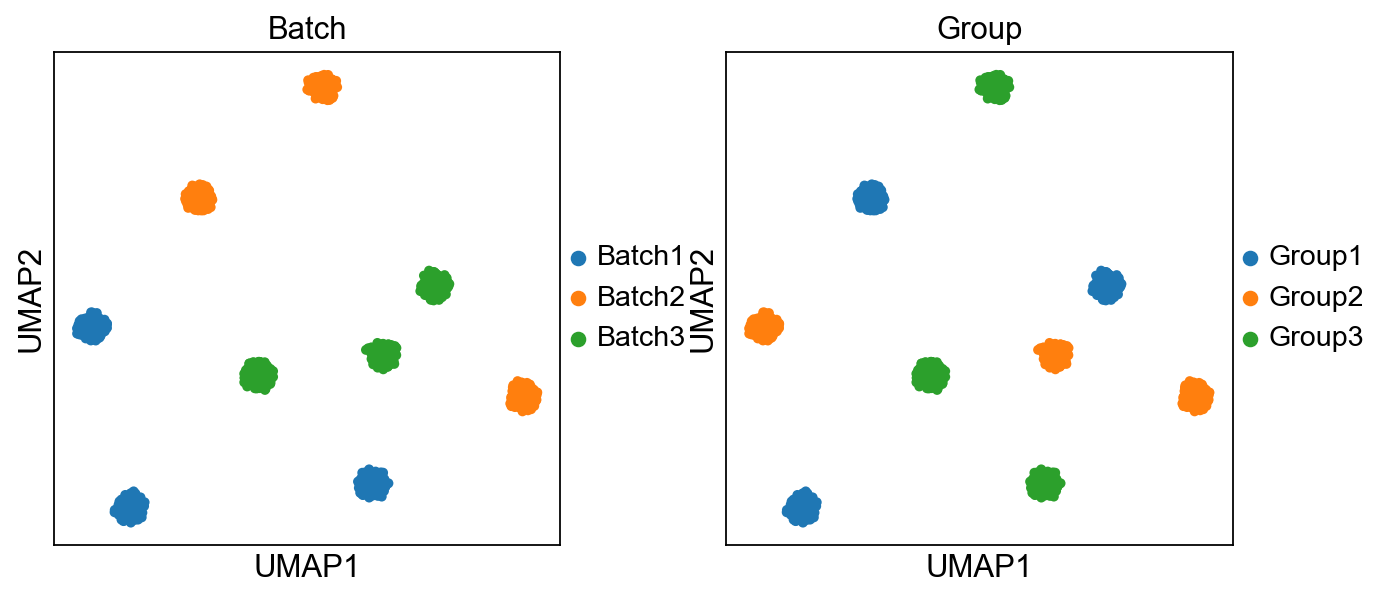

In [6]:
sc.pp.neighbors(adata, n_neighbors=9)
sc.tl.umap(adata)
sc.pl.umap(adata,color=['Batch','Group'])

Applying BBKNN leads to the cell types being reconnected across the batches.

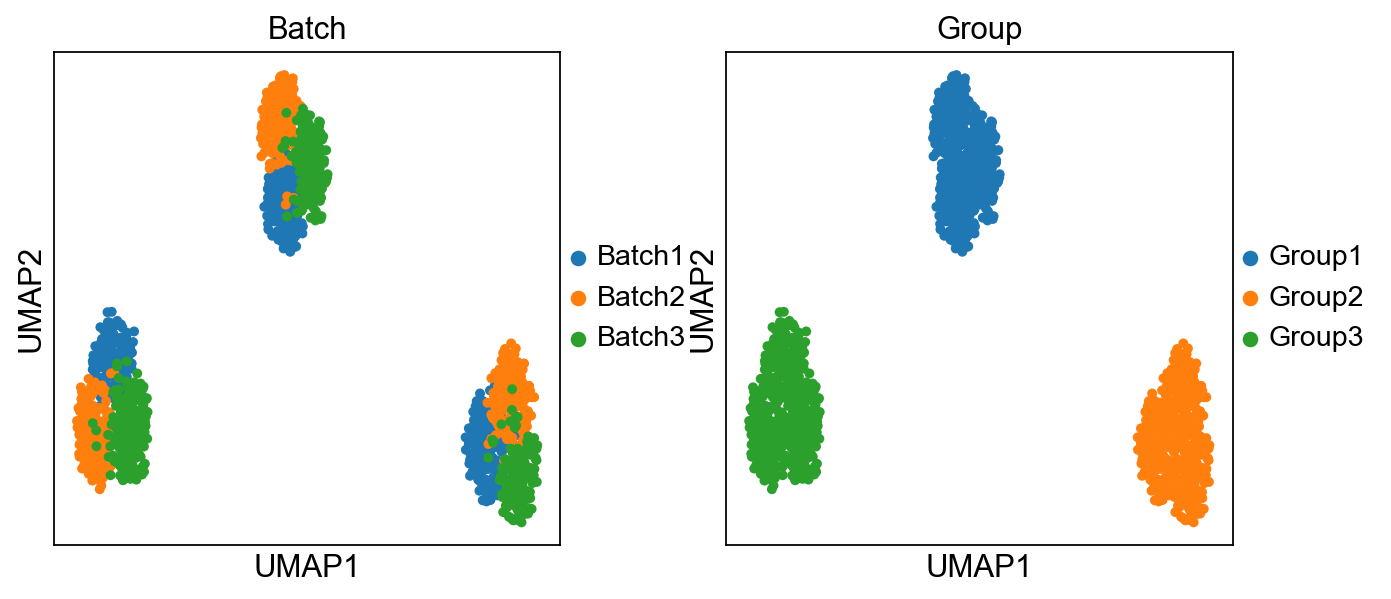

In [7]:
bbknn.bbknn(adata, batch_key='Batch', metric='euclidean')
sc.tl.umap(adata)
sc.pl.umap(adata,color=['Batch','Group'])

Let's inspect the influence of the trimming parameter. To do this, let's trim down the simulated data to a smaller setup - two batches, one has two cell types, the third has three. This is what we're left with on the original UMAP space.

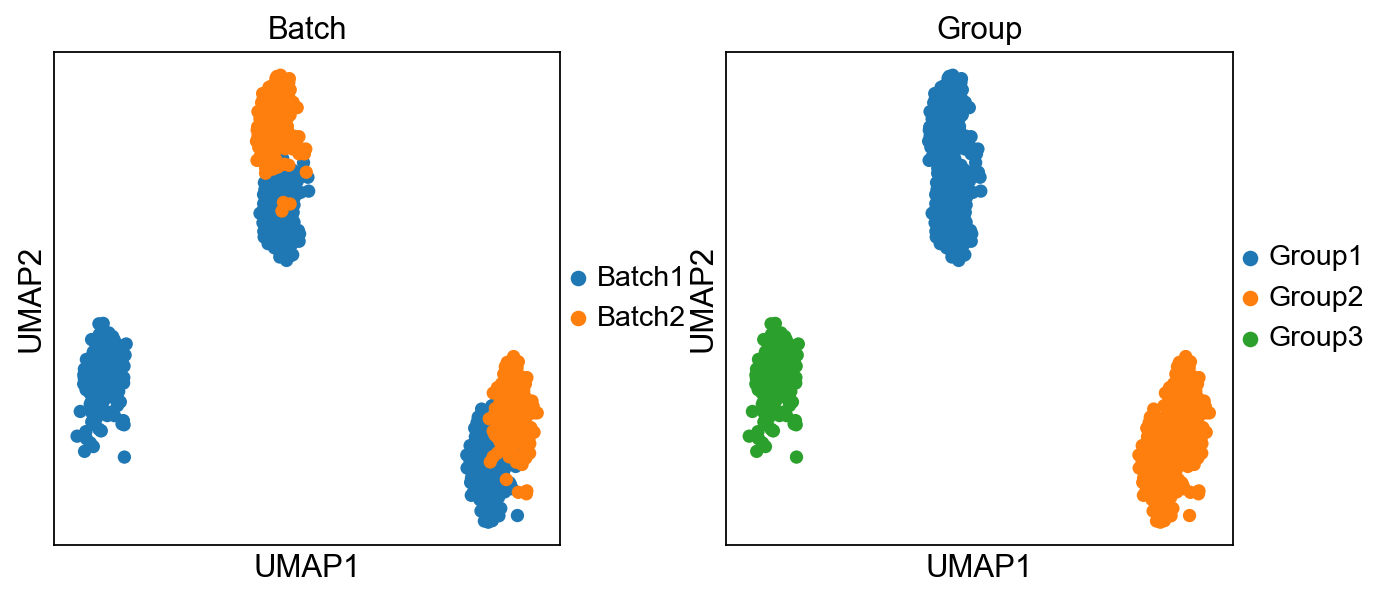

In [8]:
to_del = (adata.obs['Batch'] == 'Batch3') | ((adata.obs['Batch'] == 'Batch2') & (adata.obs['Group'] == 'Group3'))

adata2 = adata[[not i for i in to_del]]
sc.pl.umap(adata2,color=['Batch','Group'])

Running BBKNN (after re-running PCA, as we have a subset of the original cells here) without trimming the graph leads to the population present in only one of the samples being erroneously integrated with an unrelated population.

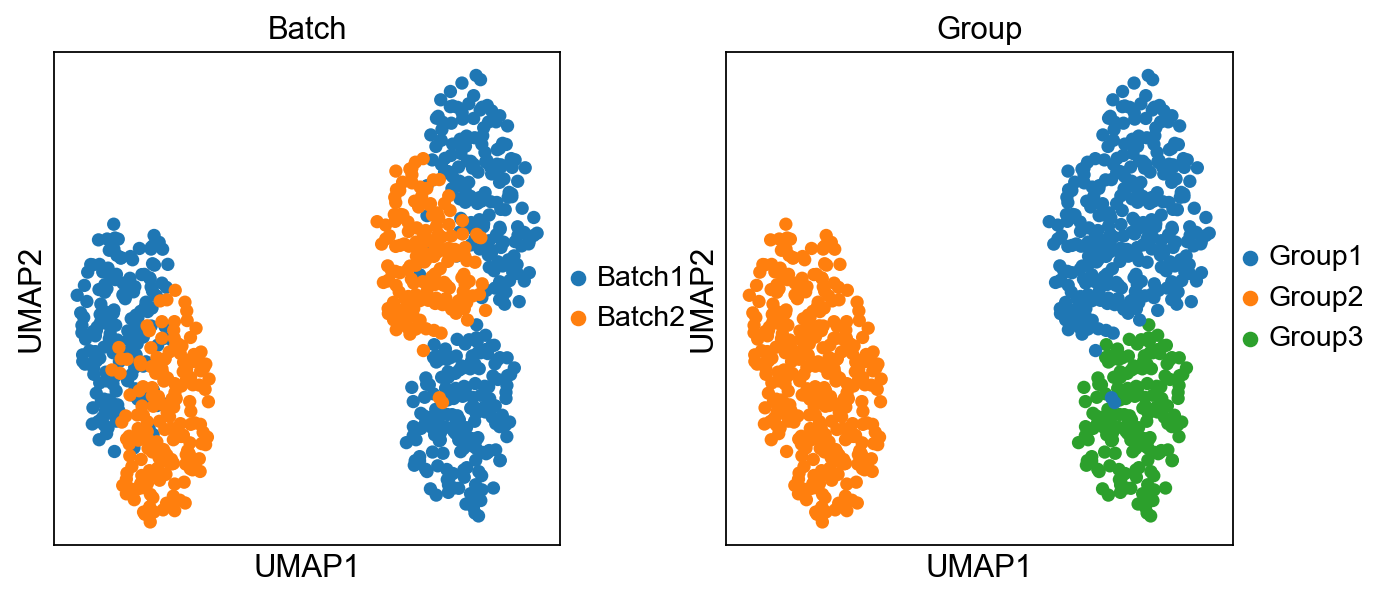

In [9]:
sc.tl.pca(adata2,svd_solver='arpack')
bbknn.bbknn(adata2, batch_key='Batch', metric='euclidean')
sc.tl.umap(adata2)
sc.pl.umap(adata2,color=['Batch','Group'])

Trimming the graph leads to the population's independence being correctly restored, while not splitting up any of the correctly merged cell types.

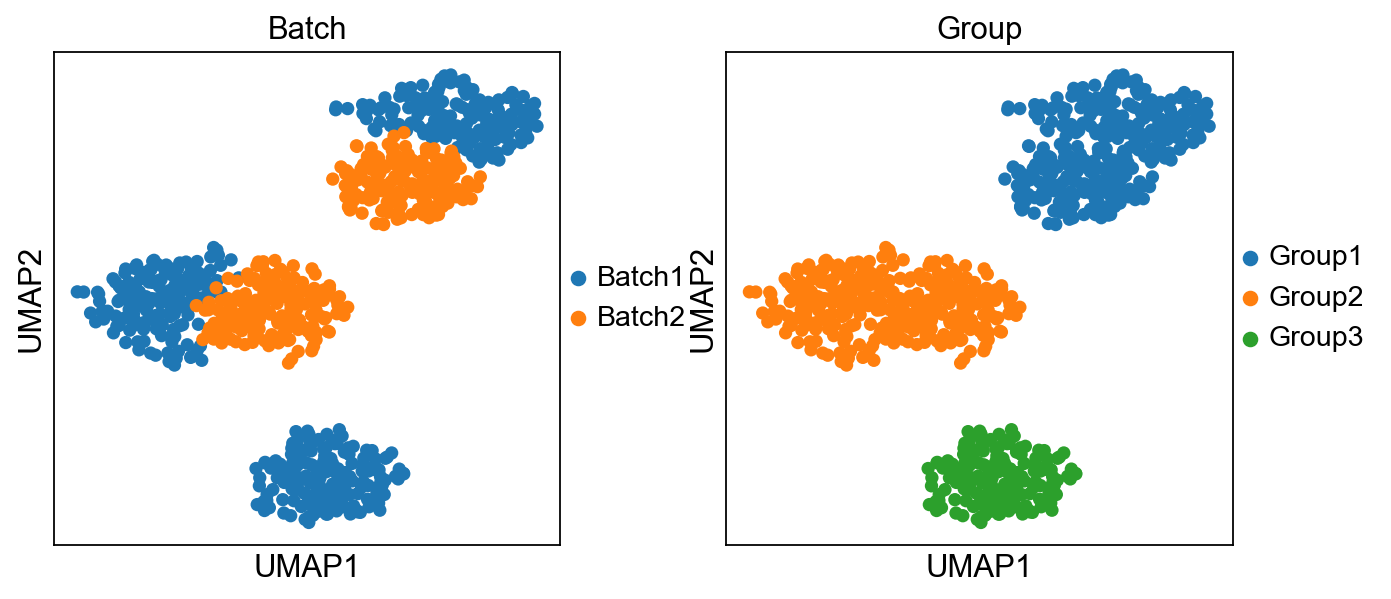

In [10]:
bbknn.bbknn(adata2, batch_key='Batch', trim=10, metric='euclidean')
sc.tl.umap(adata2)
sc.pl.umap(adata2,color=['Batch','Group'])